# Packages

In [1]:
# Data wrangling
import pandas as pd
import polars as pl
import polars.selectors as cs
import numpy as np

# Visualisation
import plotnine as pn
import matplotlib.pyplot as plt
from mizani.formatters import comma_format, custom_format, currency_format, percent_format
from IPython.display import clear_output, display
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib import rc
import plotly.express as px

# Utils
import os
from tqdm.notebook import tqdm
import itertools
import yaml
import warnings

# Modelling
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss
from sklearn.ensemble import RandomForestRegressor
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX

import ray
from ray import train, tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler


rc('text', usetex=False)

jama_colour = [
    "#374e55",
    "#df8f44",
    "#00a1d5",
    "#b24745",
    "#79af97",
    "#6a6599",
    "#80796b",
]

pd.set_option("display.max.columns", 500)
pd.set_option("display.max.columns", 500)


theme_academic = pn.theme(
    text=pn.element_text(family="Latin Modern Roman"),
    plot_title=pn.element_text(weight="bold", size=14, ha="center"),
    legend_text=pn.element_text(size=9),  # Smaller font for legend items
    panel_background=pn.element_rect(fill="white"),  # Clean white background
    panel_border=pn.element_rect(color="grey", size=0.5),
    axis_ticks=pn.element_line(color="grey"),
    panel_grid_major=pn.element_line(color="grey", size=0.1, alpha=0.3),
    panel_grid_minor=pn.element_line(color="grey", size=0.1, alpha=0.3),
    legend_background=pn.element_rect(fill="white", color=None),
    legend_key=pn.element_rect(fill="white", color=None),
    plot_margin=0.02,
    figure_size=(6, 4),  # Set default figure size (width, height in inches)
)

%matplotlib inline

# Loading the data

In [2]:
df = pl.read_csv("../0_data/preprocessed/df_final.csv", try_parse_dates=True).filter(
    pl.col("datetime") >= pd.Timestamp("2021-09-01 00:00")
)


df.head()

datetime,kWh,Basel_temperature_2m,Basel_relative_humidity_2m,Basel_dew_point_2m,Basel_apparent_temperature,Basel_precipitation,Basel_rain,Basel_snowfall,Basel_snow_depth,Basel_cloud_cover,Basel_wind_speed_10m,Basel_wind_speed_100m,Basel_wind_direction_10m,Basel_wind_direction_100m,Basel_wind_gusts_10m,Basel_soil_temperature_0_to_7cm,Basel_soil_temperature_7_to_28cm,Basel_soil_temperature_28_to_100cm,Basel_soil_temperature_100_to_255cm,Basel_soil_moisture_0_to_7cm,Basel_soil_moisture_7_to_28cm,Basel_soil_moisture_28_to_100cm,Basel_soil_moisture_100_to_255cm,Basel_shortwave_radiation,Bern_temperature_2m,Bern_relative_humidity_2m,Bern_dew_point_2m,Bern_apparent_temperature,Bern_precipitation,Bern_rain,Bern_snowfall,Bern_snow_depth,Bern_cloud_cover,Bern_wind_speed_10m,Bern_wind_speed_100m,Bern_wind_direction_10m,…,St_wind_speed_10m,St_wind_speed_100m,St_wind_direction_10m,St_wind_direction_100m,St_wind_gusts_10m,St_soil_temperature_0_to_7cm,St_soil_temperature_7_to_28cm,St_soil_temperature_28_to_100cm,St_soil_temperature_100_to_255cm,St_soil_moisture_0_to_7cm,St_soil_moisture_7_to_28cm,St_soil_moisture_28_to_100cm,St_soil_moisture_100_to_255cm,St_shortwave_radiation,Zurich_temperature_2m,Zurich_relative_humidity_2m,Zurich_dew_point_2m,Zurich_apparent_temperature,Zurich_precipitation,Zurich_rain,Zurich_snowfall,Zurich_snow_depth,Zurich_cloud_cover,Zurich_wind_speed_10m,Zurich_wind_speed_100m,Zurich_wind_direction_10m,Zurich_wind_direction_100m,Zurich_wind_gusts_10m,Zurich_soil_temperature_0_to_7cm,Zurich_soil_temperature_7_to_28cm,Zurich_soil_temperature_28_to_100cm,Zurich_soil_temperature_100_to_255cm,Zurich_soil_moisture_0_to_7cm,Zurich_soil_moisture_7_to_28cm,Zurich_soil_moisture_28_to_100cm,Zurich_soil_moisture_100_to_255cm,Zurich_shortwave_radiation
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2021-09-01 00:00:00,1.2908e6,14.276999,86.62722,12.077,14.274088,0.0,0.0,0.0,0.0,23.1,4.452954,8.0899935,14.036275,57.724377,10.440001,15.377,17.077002,16.877,15.177,0.381,0.365,0.401,0.446,0.0,11.794499,91.742035,10.494499,10.801474,0.0,0.0,0.0,0.0,1.5,7.9036193,20.140705,59.93151,…,3.319036,6.297428,130.60121,59.03632,13.32,11.744499,13.8945,14.294499,14.1445,0.416,0.423,0.403,0.413,0.0,13.192,88.84562,11.392,12.423903,0.0,0.0,0.0,0.0,4.2000003,8.217153,20.111729,28.810698,45.72514,20.519999,14.542001,16.042,16.142,15.642,0.382,0.375,0.359,0.394,0.0
2021-09-01 01:00:00,1.2694e6,13.177,91.223816,11.776999,13.115568,0.0,0.0,0.0,0.0,10.800001,4.198285,5.6233797,329.03632,39.805527,7.5599995,14.776999,16.977001,16.877,15.177,0.381,0.365,0.401,0.446,0.0,11.294499,92.32622,10.0945,10.245484,0.0,0.0,0.0,0.0,0.9,7.491114,19.770523,54.782326,…,6.3690495,9.422101,47.290634,43.451904,16.56,11.294499,13.744499,14.294499,14.1445,0.414,0.422,0.404,0.413,0.0,12.642,92.40392,11.442,11.601958,0.0,0.0,0.0,0.0,0.6,10.1887,23.233252,32.005356,40.601215,24.119999,14.192,15.892,16.142,15.642,0.381,0.375,0.359,0.394,0.0
2021-09-01 02:00:00,1.2329e6,13.377,88.56768,11.526999,13.566463,0.0,0.0,0.0,0.0,6.6000004,1.9386592,6.830519,21.801476,71.564964,6.8399997,14.627,16.977001,16.877,15.177,0.378,0.363,0.399,0.446,0.0,11.3945,91.10575,9.994499,10.04735,0.0,0.0,0.0,0.0,3.9,9.339208,21.578989,62.447273,…,4.0249224,6.297428,10.304792,30.963696,16.56,11.1945,13.744499,14.294499,14.1445,0.409,0.419,0.403,0.413,0.0,12.592,92.707214,11.442,11.363569,0.0,0.0,0.0,0.0,1.8000001,11.480557,23.469128,41.185825,48.731503,24.84,14.742001,16.042,16.142,15.642,0.378,0.374,0.358,0.394,0.0
2021-09-01 03:00:00,1.1970e6,13.077,89.72258,11.427,13.146872,0.0,0.0,0.0,0.0,0.6,2.5455842,2.7416782,278.13,23.198618,5.04,14.026999,16.827002,16.877,15.177,0.378,0.363,0.399,0.446,0.0,11.1945,92.320404,9.994499,9.884285,0.0,0.0,0.0,0.0

In [3]:
df.shape

(26304, 163)

In [4]:
df

datetime,kWh,Basel_temperature_2m,Basel_relative_humidity_2m,Basel_dew_point_2m,Basel_apparent_temperature,Basel_precipitation,Basel_rain,Basel_snowfall,Basel_snow_depth,Basel_cloud_cover,Basel_wind_speed_10m,Basel_wind_speed_100m,Basel_wind_direction_10m,Basel_wind_direction_100m,Basel_wind_gusts_10m,Basel_soil_temperature_0_to_7cm,Basel_soil_temperature_7_to_28cm,Basel_soil_temperature_28_to_100cm,Basel_soil_temperature_100_to_255cm,Basel_soil_moisture_0_to_7cm,Basel_soil_moisture_7_to_28cm,Basel_soil_moisture_28_to_100cm,Basel_soil_moisture_100_to_255cm,Basel_shortwave_radiation,Bern_temperature_2m,Bern_relative_humidity_2m,Bern_dew_point_2m,Bern_apparent_temperature,Bern_precipitation,Bern_rain,Bern_snowfall,Bern_snow_depth,Bern_cloud_cover,Bern_wind_speed_10m,Bern_wind_speed_100m,Bern_wind_direction_10m,…,St_wind_speed_10m,St_wind_speed_100m,St_wind_direction_10m,St_wind_direction_100m,St_wind_gusts_10m,St_soil_temperature_0_to_7cm,St_soil_temperature_7_to_28cm,St_soil_temperature_28_to_100cm,St_soil_temperature_100_to_255cm,St_soil_moisture_0_to_7cm,St_soil_moisture_7_to_28cm,St_soil_moisture_28_to_100cm,St_soil_moisture_100_to_255cm,St_shortwave_radiation,Zurich_temperature_2m,Zurich_relative_humidity_2m,Zurich_dew_point_2m,Zurich_apparent_temperature,Zurich_precipitation,Zurich_rain,Zurich_snowfall,Zurich_snow_depth,Zurich_cloud_cover,Zurich_wind_speed_10m,Zurich_wind_speed_100m,Zurich_wind_direction_10m,Zurich_wind_direction_100m,Zurich_wind_gusts_10m,Zurich_soil_temperature_0_to_7cm,Zurich_soil_temperature_7_to_28cm,Zurich_soil_temperature_28_to_100cm,Zurich_soil_temperature_100_to_255cm,Zurich_soil_moisture_0_to_7cm,Zurich_soil_moisture_7_to_28cm,Zurich_soil_moisture_28_to_100cm,Zurich_soil_moisture_100_to_255cm,Zurich_shortwave_radiation
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2021-09-01 00:00:00,1.2908e6,14.276999,86.62722,12.077,14.274088,0.0,0.0,0.0,0.0,23.1,4.452954,8.0899935,14.036275,57.724377,10.440001,15.377,17.077002,16.877,15.177,0.381,0.365,0.401,0.446,0.0,11.794499,91.742035,10.494499,10.801474,0.0,0.0,0.0,0.0,1.5,7.9036193,20.140705,59.93151,…,3.319036,6.297428,130.60121,59.03632,13.32,11.744499,13.8945,14.294499,14.1445,0.416,0.423,0.403,0.413,0.0,13.192,88.84562,11.392,12.423903,0.0,0.0,0.0,0.0,4.2000003,8.217153,20.111729,28.810698,45.72514,20.519999,14.542001,16.042,16.142,15.642,0.382,0.375,0.359,0.394,0.0
2021-09-01 01:00:00,1.2694e6,13.177,91.223816,11.776999,13.115568,0.0,0.0,0.0,0.0,10.800001,4.198285,5.6233797,329.03632,39.805527,7.5599995,14.776999,16.977001,16.877,15.177,0.381,0.365,0.401,0.446,0.0,11.294499,92.32622,10.0945,10.245484,0.0,0.0,0.0,0.0,0.9,7.491114,19.770523,54.782326,…,6.3690495,9.422101,47.290634,43.451904,16.56,11.294499,13.744499,14.294499,14.1445,0.414,0.422,0.404,0.413,0.0,12.642,92.40392,11.442,11.601958,0.0,0.0,0.0,0.0,0.6,10.1887,23.233252,32.005356,40.601215,24.119999,14.192,15.892,16.142,15.642,0.381,0.375,0.359,0.394,0.0
2021-09-01 02:00:00,1.2329e6,13.377,88.56768,11.526999,13.566463,0.0,0.0,0.0,0.0,6.6000004,1.9386592,6.830519,21.801476,71.564964,6.8399997,14.627,16.977001,16.877,15.177,0.378,0.363,0.399,0.446,0.0,11.3945,91.10575,9.994499,10.04735,0.0,0.0,0.0,0.0,3.9,9.339208,21.578989,62.447273,…,4.0249224,6.297428,10.304792,30.963696,16.56,11.1945,13.744499,14.294499,14.1445,0.409,0.419,0.403,0.413,0.0,12.592,92.707214,11.442,11.363569,0.0,0.0,0.0,0.0,1.8000001,11.480557,23.469128,41.185825,48.731503,24.84,14.742001,16.042,16.142,15.642,0.378,0.374,0.358,0.394,0.0
2021-09-01 03:00:00,1.1970e6,13.077,89.72258,11.427,13.146872,0.0,0.0,0.0,0.0,0.6,2.5455842,2.7416782,278.13,23.198618,5.04,14.026999,16.827002,16.877,15.177,0.378,0.363,0.399,0.446,0.0,11.1945,92.320404,9.994499,9.884285,0.0,0.0,0.0,0.0

# Preprocessing

## Missing values

Just forward fill for now.

In [5]:
df = df.fill_null(strategy="forward")

# Order Selection (Parameter Tuning)

## Visualisation

### No differencing

In [7]:
time_series = df.to_pandas()["kWh"]
acf_lags = 7 * 52

acf_x = acf(time_series, nlags=acf_lags, alpha=0.05)

acf_vals, acf_conf_int = acf_x[:2]

acf_df = pd.DataFrame(
    {
        "ACF": acf_vals,
        "ACF_low": acf_conf_int[:, 0],
        "ACF_high": acf_conf_int[:, 1],
        "Lag": np.arange(0, acf_lags + 1),
    }
)

acf_df.head()

,ACF,ACF_low,ACF_high,Lag
0,1.000000,1.000000,1.000000,0
1,0.972902,0.960817,0.984987,1
2,0.907338,0.886783,0.927893,2
3,0.823625,0.797877,0.849373,3
4,0.736739,0.707394,0.766083,4


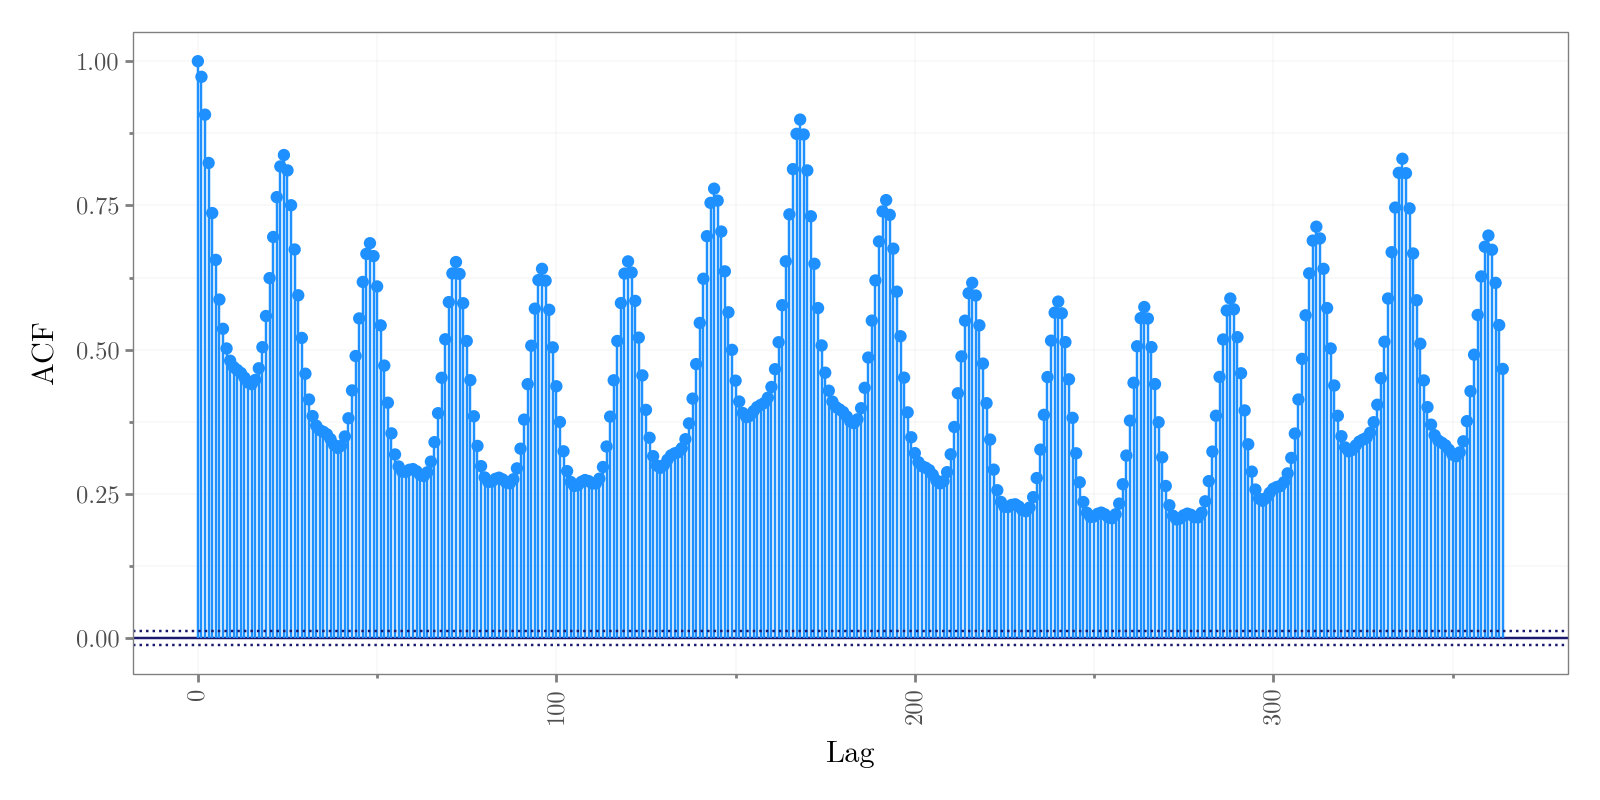

In [8]:
significance_thr = 1.96 / np.sqrt(len(time_series))

(
    pn.ggplot(acf_df, pn.aes(x="Lag", y="ACF"))
    + pn.geom_hline(yintercept=0, color="midnightblue")
    + pn.geom_segment(pn.aes(x="Lag", xend="Lag", y=0, yend="ACF"), color="dodgerblue")
    + pn.geom_point(
        color="dodgerblue",
    )
    + pn.geom_hline(
        yintercept=significance_thr, linetype="dotted", color="midnightblue"
    )
    + pn.geom_hline(
        yintercept=-significance_thr, linetype="dotted", color="midnightblue"
    )
    + theme_academic
    + pn.theme(axis_text_x=pn.element_text(rotation=90), figure_size=(8, 4))
)

In [9]:
pacf_x = pacf(time_series, nlags=acf_lags, alpha=0.05)

pacf_vals, pacf_conf_int = pacf_x[:2]

pacf_df = pd.DataFrame(
    {
        "PACF": pacf_vals,
        "PACF_low": pacf_conf_int[:, 0],
        "PACF_high": pacf_conf_int[:, 1],
        "Lag": np.arange(0, acf_lags + 1),
    }
)

pacf_df.head()

,PACF,PACF_low,PACF_high,Lag
0,1.000000,1.000000,1.000000,0
1,0.972939,0.960854,0.985024,1
2,-0.734299,-0.746384,-0.722215,2
3,0.285290,0.273205,0.297374,3
4,-0.003155,-0.015240,0.008930,4


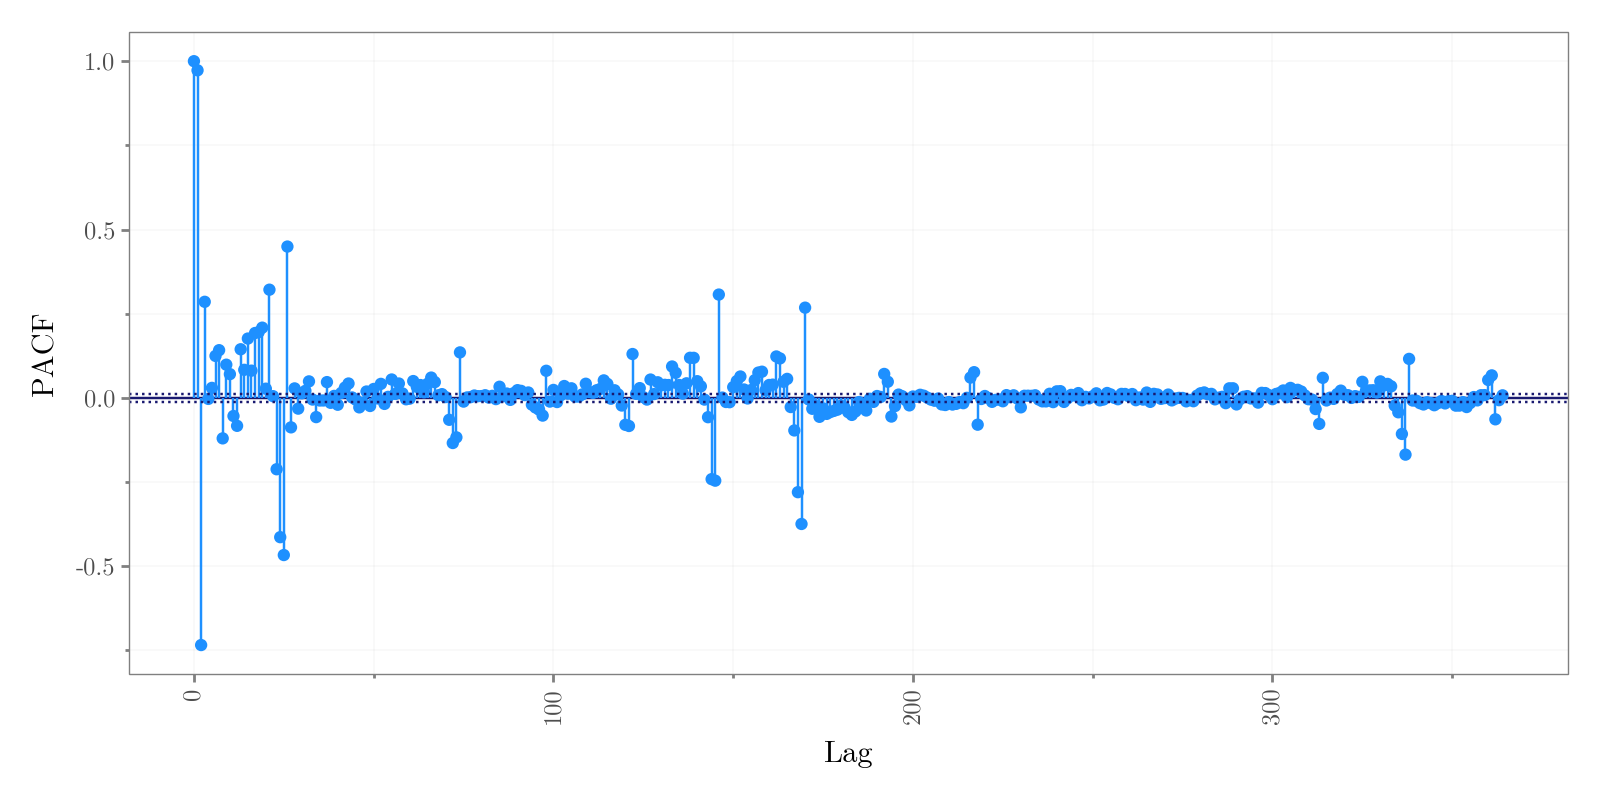

In [10]:
significance_thr = 1.96 / np.sqrt(len(time_series))

(
    pn.ggplot(pacf_df, pn.aes(x="Lag", y="PACF"))
    + pn.geom_hline(yintercept=0, color="midnightblue")
    + pn.geom_segment(pn.aes(x="Lag", xend="Lag", y=0, yend="PACF"), color="dodgerblue")
    + pn.geom_point(
        color="dodgerblue",
    )
    + pn.geom_hline(
        yintercept=significance_thr, linetype="dotted", color="midnightblue"
    )
    + pn.geom_hline(
        yintercept=-significance_thr, linetype="dotted", color="midnightblue"
    )
    + theme_academic
    + pn.theme(axis_text_x=pn.element_text(rotation=90), figure_size=(8, 4))
)

In [11]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [12]:
kpss_test(time_series)

Results of KPSS Test:
Test Statistic            3.932698
p-value                   0.010000
Lags Used                86.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\mathi\AppData\Local\Temp\ipykernel_17952\11026176.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.



### First order differencing

In [13]:
time_series = df.to_pandas()["kWh"]
time_series = (time_series - time_series.shift(1)).dropna()

acf_x = acf(time_series, nlags=acf_lags, alpha=0.05)

acf_vals, acf_conf_int = acf_x[:2]

acf_df = pd.DataFrame(
    {
        "ACF": acf_vals,
        "ACF_low": acf_conf_int[:, 0],
        "ACF_high": acf_conf_int[:, 1],
        "Lag": np.arange(0, acf_lags + 1),
    }
)

acf_df.head()

,ACF,ACF_low,ACF_high,Lag
0,1.000000,1.000000,1.000000,0
1,0.711018,0.698934,0.723103,1
2,0.335399,0.318261,0.352537,2
3,0.058688,0.040617,0.076759,3
4,-0.106215,-0.124315,-0.088116,4


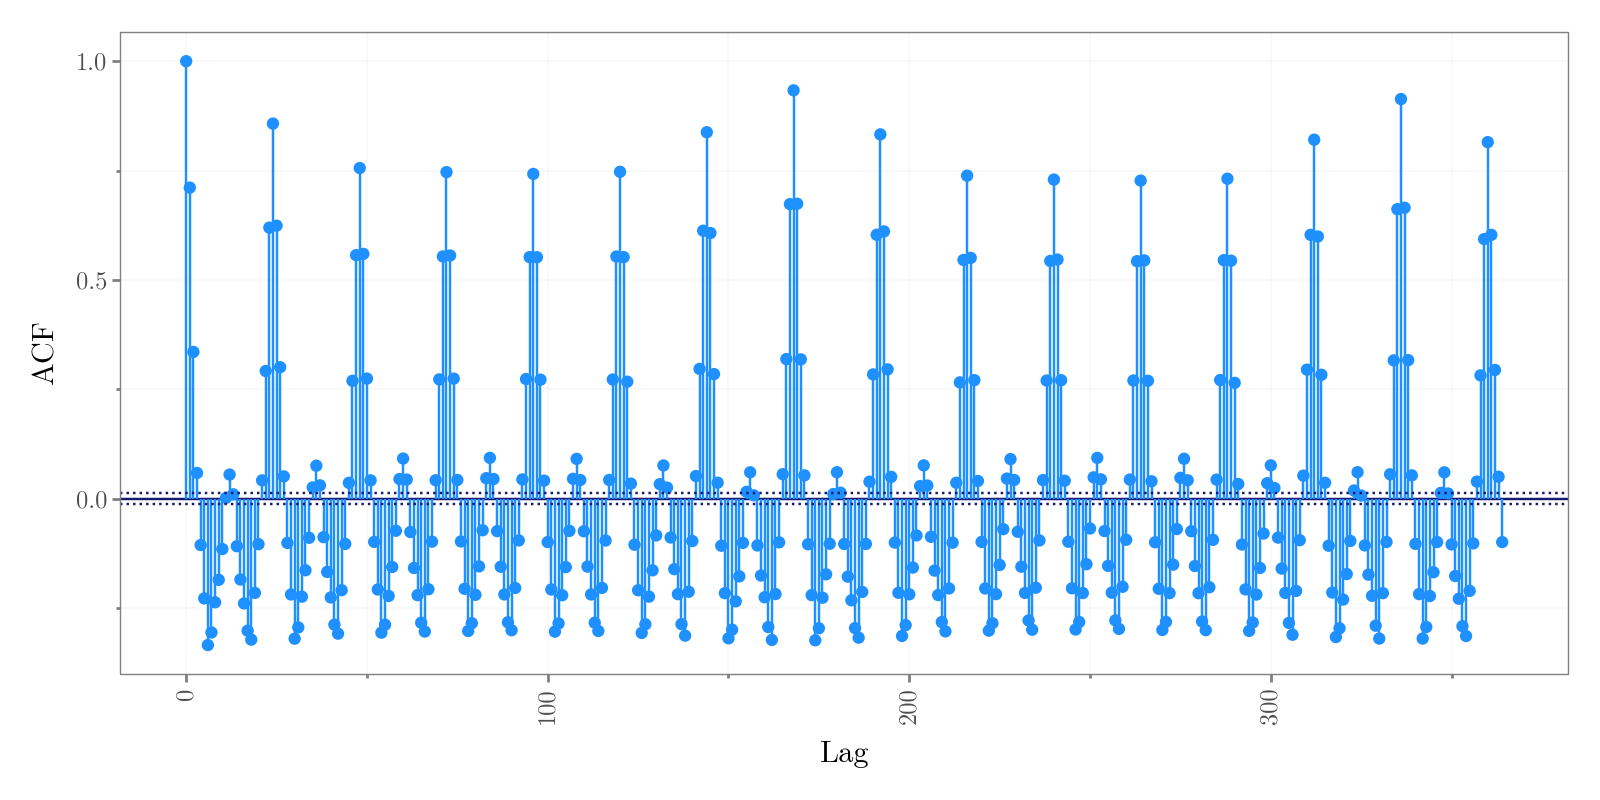

In [14]:
significance_thr = 1.96 / np.sqrt(len(time_series))

(
    pn.ggplot(acf_df, pn.aes(x="Lag", y="ACF"))
    + pn.geom_hline(yintercept=0, color="midnightblue")
    + pn.geom_segment(pn.aes(x="Lag", xend="Lag", y=0, yend="ACF"), color="dodgerblue")
    + pn.geom_point(
        color="dodgerblue",
    )
    + pn.geom_hline(
        yintercept=significance_thr, linetype="dotted", color="midnightblue"
    )
    + pn.geom_hline(
        yintercept=-significance_thr, linetype="dotted", color="midnightblue"
    )
    + theme_academic
    + pn.theme(axis_text_x=pn.element_text(rotation=90), figure_size=(8, 4))
)

In [15]:
pacf_x = pacf(time_series, nlags=acf_lags, alpha=0.05)

pacf_vals, pacf_conf_int = pacf_x[:2]

pacf_df = pd.DataFrame(
    {
        "PACF": pacf_vals,
        "PACF_low": pacf_conf_int[:, 0],
        "PACF_high": pacf_conf_int[:, 1],
        "Lag": np.arange(0, acf_lags + 1),
    }
)

pacf_df.head()

,PACF,PACF_low,PACF_high,Lag
0,1.000000,1.000000,1.000000,0
1,0.711046,0.698961,0.723130,1
2,-0.344167,-0.356252,-0.332082,2
3,-0.039404,-0.051489,-0.027319,3
4,-0.070561,-0.082645,-0.058476,4


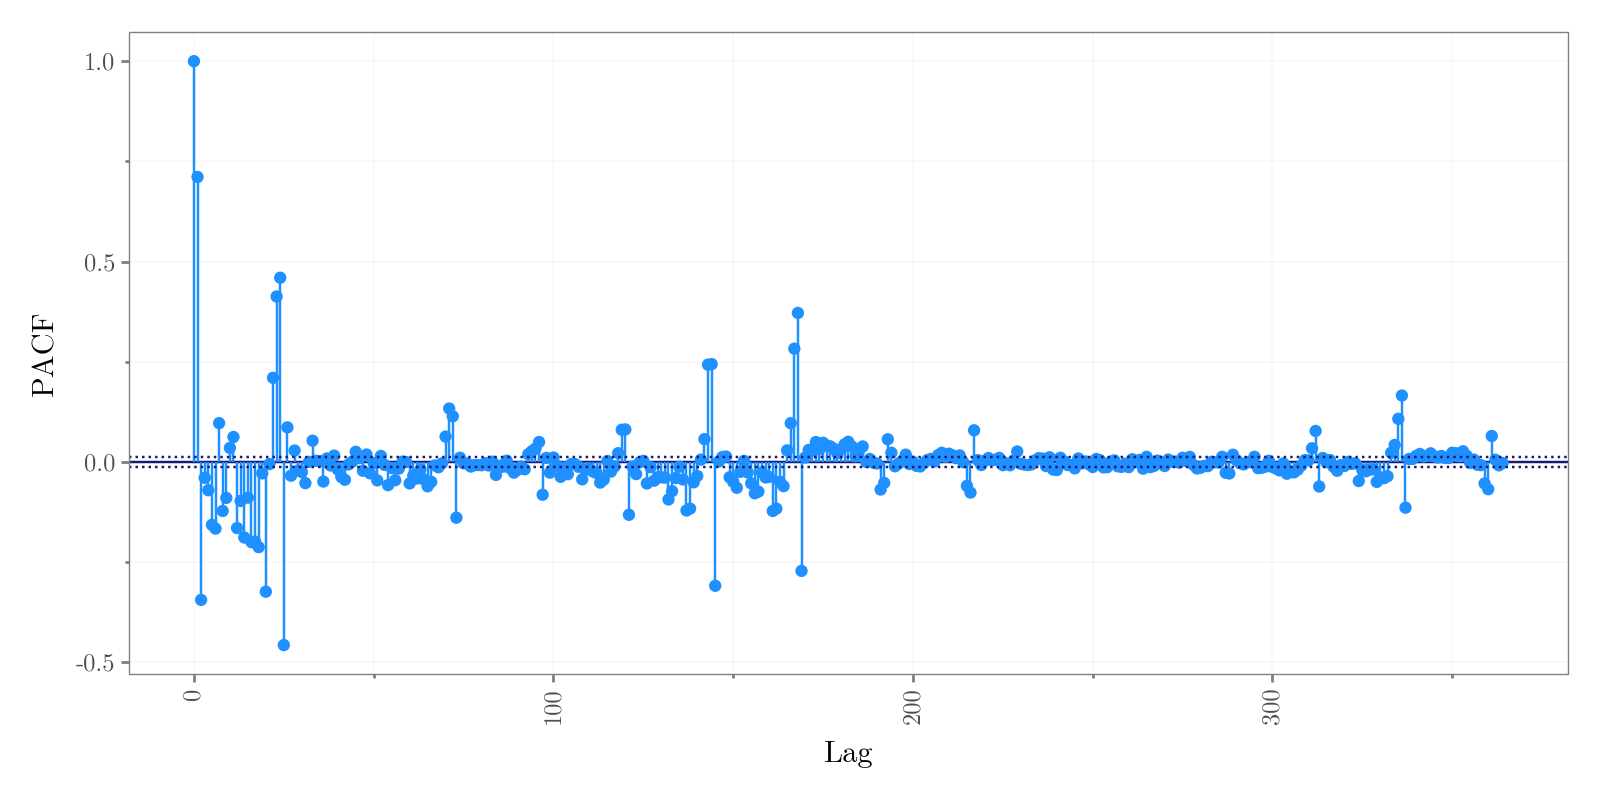

In [16]:
significance_thr = 1.96 / np.sqrt(len(time_series))

(
    pn.ggplot(pacf_df, pn.aes(x="Lag", y="PACF"))
    + pn.geom_hline(yintercept=0, color="midnightblue")
    + pn.geom_segment(pn.aes(x="Lag", xend="Lag", y=0, yend="PACF"), color="dodgerblue")
    + pn.geom_point(
        color="dodgerblue",
    )
    + pn.geom_hline(
        yintercept=significance_thr, linetype="dotted", color="midnightblue"
    )
    + pn.geom_hline(
        yintercept=-significance_thr, linetype="dotted", color="midnightblue"
    )
    + theme_academic
    + pn.theme(axis_text_x=pn.element_text(rotation=90), figure_size=(8, 4))
)

In [17]:
kpss_test(time_series)

Results of KPSS Test:
Test Statistic             0.023294
p-value                    0.100000
Lags Used                379.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


C:\Users\mathi\AppData\Local\Temp\ipykernel_17952\11026176.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.



### Second order differencing

In [18]:
time_series = df.to_pandas()["kWh"]
time_series = (time_series - time_series.shift(1)).dropna()
time_series = (time_series - time_series.shift(1)).dropna()

acf_x = acf(time_series, nlags=acf_lags, alpha=0.05)

acf_vals, acf_conf_int = acf_x[:2]

acf_df = pd.DataFrame(
    {
        "ACF": acf_vals,
        "ACF_low": acf_conf_int[:, 0],
        "ACF_high": acf_conf_int[:, 1],
        "Lag": np.arange(0, acf_lags + 1),
    }
)

acf_df.head()

,ACF,ACF_low,ACF_high,Lag
0,1.000000,1.000000,1.000000,0
1,0.149948,0.137862,0.162033,1
2,-0.171152,-0.183506,-0.158798,2
3,-0.193418,-0.206114,-0.180723,3
4,-0.074484,-0.087603,-0.061365,4


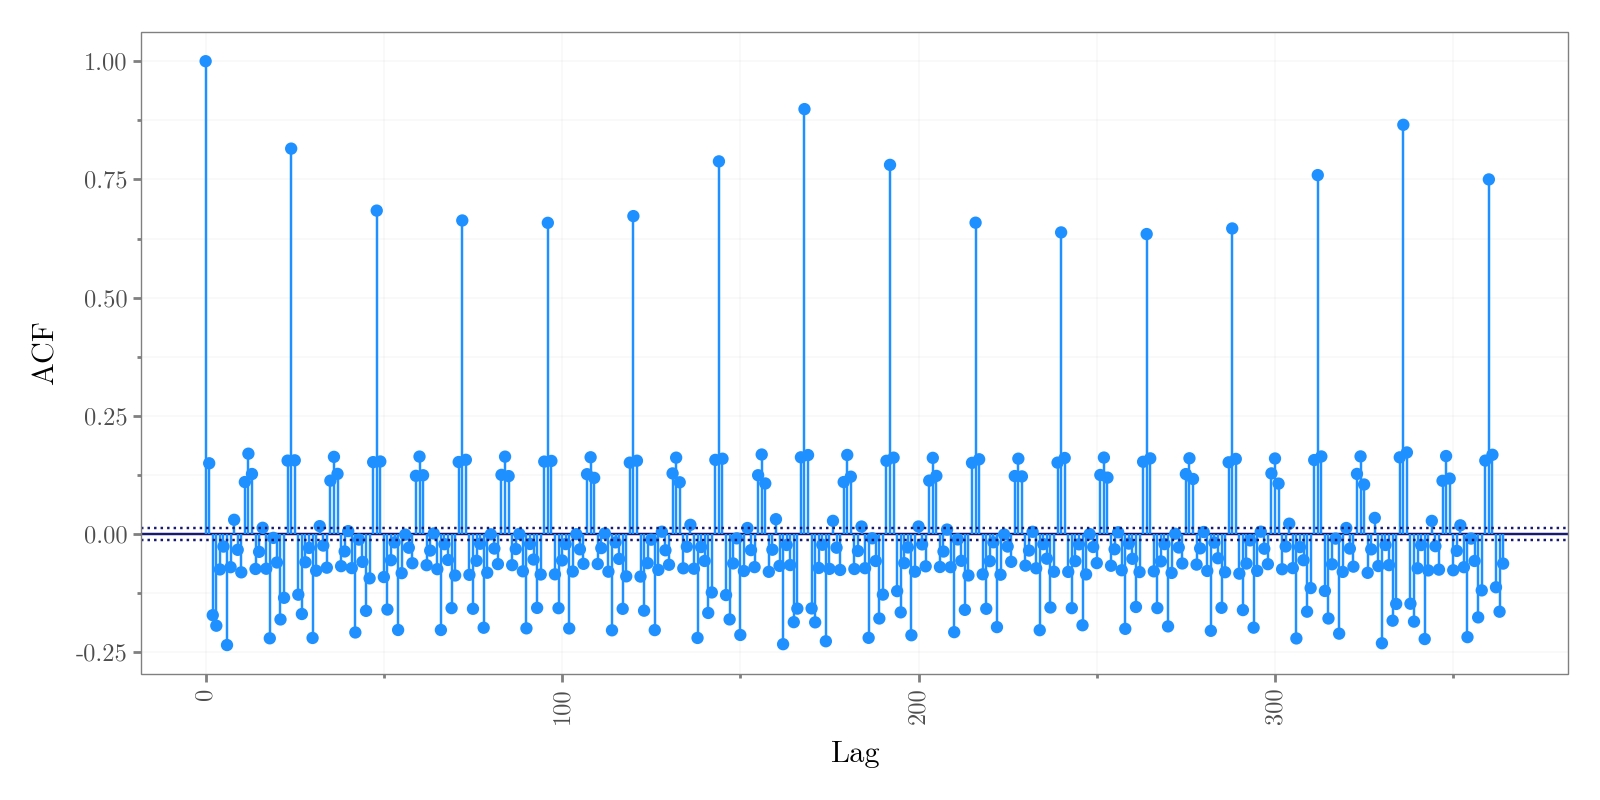

In [19]:
significance_thr = 1.96 / np.sqrt(len(time_series))

(
    pn.ggplot(acf_df, pn.aes(x="Lag", y="ACF"))
    + pn.geom_hline(yintercept=0, color="midnightblue")
    + pn.geom_segment(pn.aes(x="Lag", xend="Lag", y=0, yend="ACF"), color="dodgerblue")
    + pn.geom_point(
        color="dodgerblue",
    )
    + pn.geom_hline(
        yintercept=significance_thr, linetype="dotted", color="midnightblue"
    )
    + pn.geom_hline(
        yintercept=-significance_thr, linetype="dotted", color="midnightblue"
    )
    + theme_academic
    + pn.theme(axis_text_x=pn.element_text(rotation=90), figure_size=(8, 4))
)

In [20]:
pacf_x = pacf(time_series, nlags=acf_lags, alpha=0.05)

pacf_vals, pacf_conf_int = pacf_x[:2]

pacf_df = pd.DataFrame(
    {
        "PACF": pacf_vals,
        "PACF_low": pacf_conf_int[:, 0],
        "PACF_high": pacf_conf_int[:, 1],
        "Lag": np.arange(0, acf_lags + 1),
    }
)

pacf_df.head()

,PACF,PACF_low,PACF_high,Lag
0,1.000000,1.000000,1.000000,0
1,0.149953,0.137868,0.162038,1
2,-0.198105,-0.210190,-0.186020,2
3,-0.141599,-0.153684,-0.129513,3
4,-0.058120,-0.070206,-0.046035,4


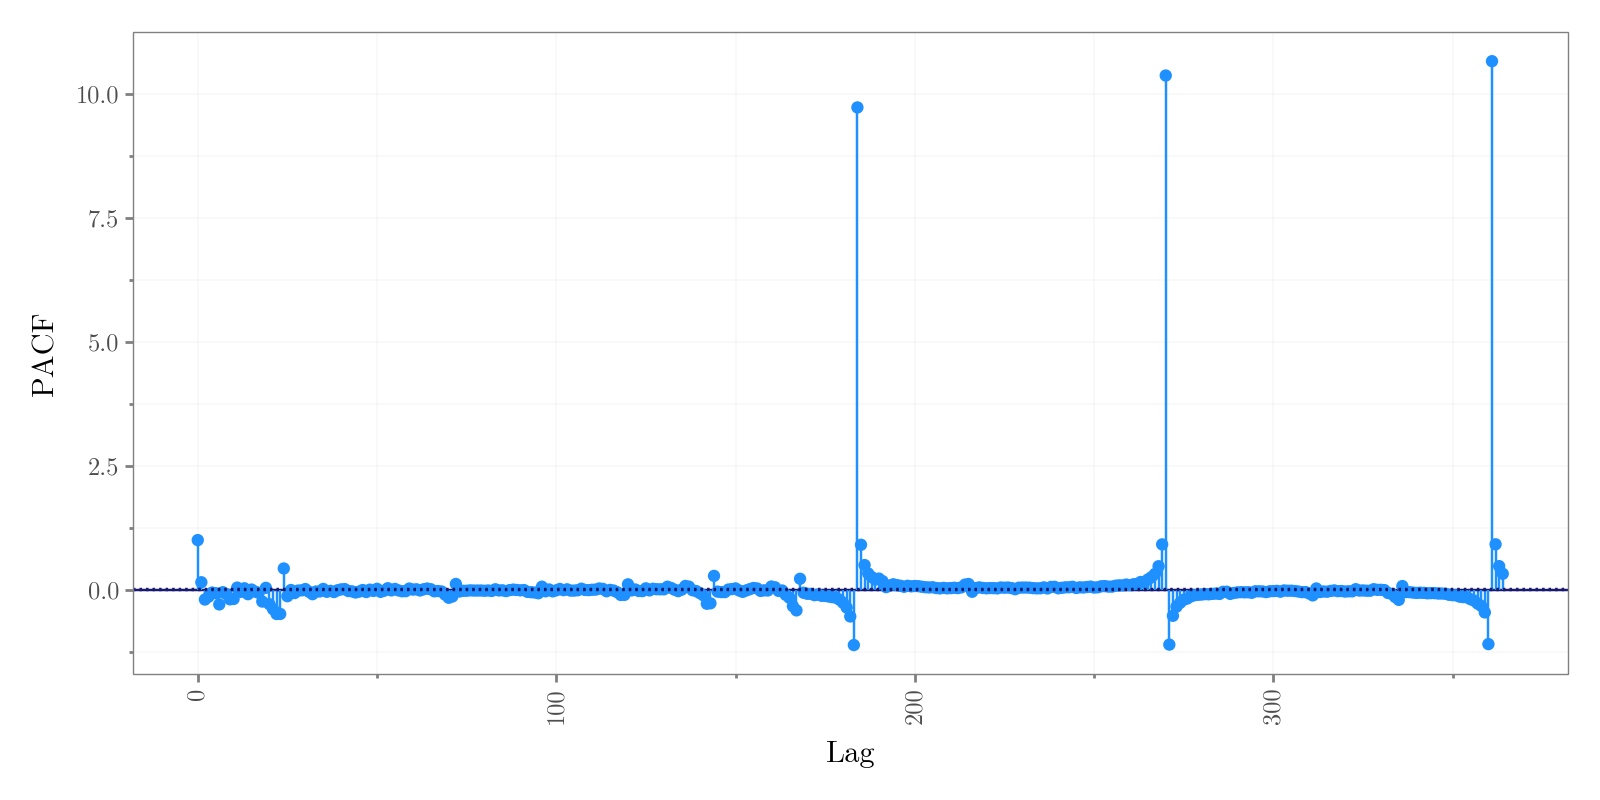

In [21]:
significance_thr = 1.96 / np.sqrt(len(time_series))

(
    pn.ggplot(pacf_df, pn.aes(x="Lag", y="PACF"))
    + pn.geom_hline(yintercept=0, color="midnightblue")
    + pn.geom_segment(pn.aes(x="Lag", xend="Lag", y=0, yend="PACF"), color="dodgerblue")
    + pn.geom_point(
        color="dodgerblue",
    )
    + pn.geom_hline(
        yintercept=significance_thr, linetype="dotted", color="midnightblue"
    )
    + pn.geom_hline(
        yintercept=-significance_thr, linetype="dotted", color="midnightblue"
    )
    + theme_academic
    + pn.theme(axis_text_x=pn.element_text(rotation=90), figure_size=(8, 4))
)

## Tuning

Order selection:

- p
- d
- q
- P
- D
- Q
- s


p,d,P,Q can be specified using tuples, so as to not include ALL lags up to a certain frequency: 
- Will help with the issue of computational complexity
- How to tune?
    - First set "horizon", then select which lags to turn on. Might set a real long one (like one week) but only activate a few of them
    - Simulated Annealing?

When predicting using last_window and last_window_exog, the internal statsmodels SARIMAX will be updated using its append method. To do this, last_window data must start at the end of the index seen by the forecaster, this is stored in forecaster.extended_index.

In [22]:
df_full = (
    df.to_pandas()
    .assign(datetime=lambda x: x.datetime.astype("datetime64[ns]"))
    .set_index("datetime")
    .asfreq("h")
    .sort_index()
)
df_full.head()

,kWh,Basel_precipitation,Basel_soil_temperature_7_to_28cm,Basel_shortwave_radiation,Bern_precipitation,Bern_soil_temperature_7_to_28cm,Bern_shortwave_radiation,Geneva_precipitation,Geneva_soil_temperature_7_to_28cm,Geneva_shortwave_radiation,Lugano_precipitation,Lugano_soil_temperature_7_to_28cm,Lugano_shortwave_radiation,Sion_precipitation,Sion_soil_temperature_7_to_28cm,Sion_shortwave_radiation,St_precipitation,St_soil_temperature_7_to_28cm,St_shortwave_radiation,Zurich_precipitation,Zurich_soil_temperature_7_to_28cm,Zurich_shortwave_radiation
datetime,,,,,,,,,,,,,,,,,,,,,,
2021-09-01 00:00:00,1.290817e+06,0.0,17.077002,0.0,0.0,15.194500,0.0,0.0,18.264000,0.0,0.0,19.579,0.0,0.0,17.898,0.0,0.0,13.894500,0.0,0.0,16.042000,0.0
2021-09-01 01:00:00,1.269414e+06,0.0,16.977001,0.0,0.0,15.094500,0.0,0.0,18.164000,0.0,0.0,19.429,0.0,0.0,17.698,0.0,0.0,13.744499,0.0,0.0,15.892000,0.0
2021-09-01 02:00:00,1.232882e+06,0.0,16.977001,0.0,0.0,15.044499,0.0,0.0,18.164000,0.0,0.0,19.129,0.0,0.0,17.448,0.0,0.0,13.744499,0.0,0.0,16.042000,0.0
2021-09-01 03:00:00,1.196958e+06,0.0,16.827002,0.0,0.0,14.944500,0.0,0.0,18.064001,0.0,0.0,18.929,0.0,0.0,17.298,0.0,0.0,13.544499,0.0,0.0,15.942000,0.0
2021-09-01 04:00:00,1.175961e+06,0.0,16.677000,0.0,0.0,14.844500,0.0,0.0,17.964000,0.0,0.0,18.679,0.0,0.0,17.098,0.0,0.0,13.344500,0.0,0.0,15.792001,0.0


In [23]:
df_train = df_full["2021-09-01":"2022-08-31"]
df_val = df_full["2022-09-01":"2023-08-31"]

In [24]:
### Manual Test

In [25]:
forecaster = ForecasterSarimax(
    regressor=Sarimax(
        order=(1, 1, 1),
        # seasonal_order=(1, 1, 1, 2),
    )
)

forecaster.fit(
    y=df_train["kWh"], exog=df_train.drop(columns=["kWh"]), suppress_warnings=True
)

In [26]:
def validation(model, df_val, verbose=True):
    # Validation loop (predict the next 24 hours)
    val_index = 0
    horizon = 24
    val_preds = []

    while val_index + horizon <= df_val.shape[0]:

        # Check for first day after validation period
        if val_index == 0:
            # Get date from D+1
            df_pred_day = df_val.iloc[val_index : val_index + horizon]

            # Make prediction
            y_pred = model.predict(steps=24, exog=df_val.drop(columns=["kWh"]))

            # Save prediction
            val_preds.append(df_pred_day.filter(["kWh"]).join(y_pred))

            # Set D+0 to what was previously D+1
            df_current_day = df_pred_day

        # All other days after first day
        else:
            # Get date from D+1
            df_pred_day = df_val.iloc[val_index : val_index + horizon]

            # Make prediction
            y_pred = model.predict(
                steps=24,
                exog=df_pred_day.drop(columns=["kWh"]),
                last_window=df_current_day["kWh"],
                last_window_exog=df_current_day.drop(columns=["kWh"]),
            )

            # Save prediction
            val_preds.append(df_pred_day.filter(["kWh"]).join(y_pred))

            # Set D+0 to what was previously D+1
            df_current_day = df_pred_day

        val_index += horizon

        if val_index % (24 * 7) == 0:
            print(f"Hour {val_index} of {df_val.shape[0]}")
            clear_output(wait=True)

    y_preds_val = pd.concat(val_preds)

    return y_preds_val

In [27]:
y_preds_val = validation(model=forecaster, df_val=df_val)

Hour 8736 of 8760


In [28]:
fig = px.line(
    y_preds_val.reset_index(),
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Actual vs Predicted Energy Consumption Over Time",
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="kWh",
)

In [29]:
def sarimax_trainable(config, eval_option="in-sample"):

    try:
        # Fit the model on the training data
        forecaster = ForecasterSarimax(
            regressor=Sarimax(
                order=(config["p"], config["d"], config["q"]),
                seasonal_order=(config["P"], config["D"], config["Q"], 168),
            )
        )

        forecaster.fit(
            y=df_train["kWh"],
            exog=df_train.drop(columns=["kWh"]),
            suppress_warnings=True,
        )

        if eval_option == "in-sample":
            # Get the Information Criterion
            inf_criterion = forecaster.regressor.get_info_criteria("aic")
            train.report({"loss": inf_criterion})
        elif eval_option == "out-of-sample":
            y_preds_val = validation(forecaster)
            loss = root_mean_squared_error(
                y_pred=y_preds_val["pred"], y_true=y_preds_val["kWh"]
            )
            train.report({"loss": loss})

    except Exception as e:
        tune.report(metric=float("inf"))

In [ ]:
# Need this line for locally defined modules to work with ray
# ray.init(runtime_env={"working_dir": "."}, ignore_reinit_error=True)
np.random.seed(42)

analysis = tune.run(
    tune.with_parameters(
        sarimax_trainable,
        eval_option="out-of-sample",
    ),
    config={
        "p": tune.randint(1, 168),
        "q": tune.randint(1, 168),
        "P": tune.randint(1, 24),
        "Q": tune.randint(1, 24),
        "d": tune.randint(1, 5),
        "D": tune.randint(1, 5),
    },
    metric="loss",
    mode="min",
    name="SARIMAX",
    search_alg=OptunaSearch(),
    time_budget_s=60 * 60 * 1.5,
    num_samples=-1,
    raise_on_failed_trial=False,
    trial_dirname_creator=lambda trial: f"{trial.trainable_name}_{trial.trial_id}",
)

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\ray\_private\node.py:1362: ResourceWarning:

unclosed file <_io.TextIOWrapper name='C:\\Users\\mathi\\AppData\\Local\\Temp\\ray\\session_2024-10-30_09-59-24_723195_17952\\logs\\gcs_server.out' mode='a' encoding='utf-8'>

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\ray\_private\node.py:1362: ResourceWarning:

unclosed file <_io.TextIOWrapper name='C:\\Users\\mathi\\AppData\\Local\\Temp\\ray\\session_2024-10-30_09-59-24_723195_17952\\logs\\gcs_server.err' mode='a' encoding='utf-8'>

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\ray\_private\node.py:1367: ResourceWarning:

unclosed file <_io.TextIOWrapper name='C:\\Users\\mathi\\AppData\\Local\\Temp\\ray\\session_2024-10-30_09-59-24_723195_17952\\logs\\monitor.out' mode='a' encoding='utf-8'>

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\ray\_private\node.py:1367: ResourceWarning:

unclosed file <_io.TextIOWrapper name='C:\\Users\\mathi\\AppData\\Local\\Te

2024-10-30 10:10:14,318	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-10-30 10:10:14,421	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/mathi/ray_results/SARIMAX' in 0.1020s.


In [15]:
analysis.dataframe().to_csv("2_SARIMAX_trials.csv", index=False)

NameError: name 'analysis' is not defined

# Model Evaluation